# CS 6120: Natural Language Processing
## Final Project: Music Genre Classification
## Authors: Bharat Chawla and Himaja R. Ginkala

In [1]:
# importing libraries
import csv
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from keras.layers import Dense, Flatten, LSTM, Layer, MaxPooling1D, Dropout, Activation, Attention
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

df_english_cleaned = pd.read_csv('english_cleaned.csv')

FileNotFoundError: ignored

In [ ]:
# load data from CSV file
#df_english_cleaned = pd.read_csv('english_cleaned.csv')

#### Vocabulary

In [ ]:
# load vocabulary from file
with open('vocabulary.txt', "r") as f:
    vocabulary = f.readlines()

print("Vocabulary Size: ", len(vocabulary))

# replace new line characters
vocabulary = list(map(lambda s: s.strip(), vocabulary))

In [ ]:
# create word to id dictionary
word_to_id = {}
for i, word in enumerate(vocabulary):
  word_to_id[word] = i + 1

#### Glove Embeddings

In [ ]:
# open glove embeddings file
glove_file = open('glove.6B.100d.txt')

glove_embeddings = {}
for line in glove_file:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype = 'float32')
  glove_embeddings[word] = coefs

glove_file.close()

all_glove_words = list(glove_embeddings.keys())
print("Found %s word vectors." % len(glove_embeddings))

#### Embedding Matrix

In [ ]:
embedding_matrix = np.zeros((len(vocabulary), 100))

for word, i in word_to_id.items():
  embedding_vector = glove_embeddings.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

### Data Preparation

In [ ]:
# get only data with cleaned lyrics
df_english = df_english_cleaned[df_english_cleaned['Cleaned_Lyric'].notna()]

#### Genre Separation

In [ ]:
# convert multi-valued column to single value
for i, row in df_english.iterrows():
  if ";" in str(df_english.at[i, 'Genres']):
    genres = df_english.at[i, 'Genres'].split("; ")
    df_english.at[i, 'Genres'] = genres[0]

#rename column
df_english.rename(columns = {'Genres':'Genre'}, inplace = True)
df_english['Genre'] = df_english['Genre'].replace('Pop/Rock', 'Pop-Rock')
df_english

In [ ]:
# get genre count
genre_counts = df_english['Genre'].value_counts()
print("Number of English Genres: ", genre_counts)

# get genre names
genre_names = df_english['Genre'].value_counts().index.tolist()

In [ ]:
# create dataframe of only top 10 genres in English
top_10_genres = genre_names[0:10]
df_english_top_10_genres = df_english[df_english['Genre'].isin(top_10_genres)]
df_english_top_10_genres

In [ ]:
# reset indices
df_english_top_10_genres = df_english_top_10_genres.reset_index(drop = True)
df_english_top_10_genres

#### Label Creation

In [ ]:
# create labels
genre_labels = []
for genre in df_english_top_10_genres['Genre'].tolist():
  genre_labels.append(top_10_genres.index(genre))

print("Length of Labels List: ", len(genre_labels))

In [ ]:
df_english_top_10_genres['Label'] = genre_labels
print(df_english_top_10_genres['Label'].value_counts())

#### Balancing Dataset

In [ ]:
# create a balanced dataset starting with top genre
df_balanced = df_english_top_10_genres[df_english_top_10_genres.Genre == top_10_genres[0]].sample(2000)

# get n random rows from each of the other top genres
for genre in top_10_genres[1:]:
  df_genre = df_english_top_10_genres[df_english_top_10_genres.Genre == genre].sample(2000)
  df_balanced = pd.concat([df_balanced, df_genre], ignore_index = True)

# ensure dataset is balanced
df_balanced['Genre'].value_counts()

#### Tokenization and Encoding

In [ ]:
lyrics = df_balanced['Cleaned_Lyric'].tolist()

tokens = []
for lyric in lyrics:
  try:
    words = word_tokenize(lyric)
  except:
    print(lyric)

  tokens.append(words)

print("Length of Tokens List: ", len(tokens))

In [ ]:
encoded_tokens = []

# for every lyric
for line in tokens:
  encoded_line = []

  # for every word in lyric
  for word in line:
    # set to id value
    encoded_line.append(word_to_id.get(word))

  encoded_tokens.append(encoded_line)

print("Length of Encoded Tokens: ", len(encoded_tokens))

#### Padding

In [ ]:
# get max length in list
max_length = len(max(encoded_tokens, key = len))
# pad training data
X = pad_sequences(encoded_tokens, maxlen = max_length)

In [ ]:
# convert to numpy arrays
X = np.array(X)
y = np.array(df_balanced['Label'].tolist())

# one hot encode labels
y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

#### Data Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = 42,
    test_size = 0.3,
    shuffle = True)

### Model Creation

In [ ]:
# global variables
EPOCHS = 15
DROPOUT = 0.2
LEARNING_RATE = 0.003
BATCH_SIZE = 100

VOCAB_SIZE = len(vocabulary)
OUTPUT_SIZE = 10
N_LAYERS = 2
HIDDEN_DIM = 128
EMBEDDING_DIM = 100

In [ ]:
def build_model(X):

  # set input layer
  input_layer = tf.keras.Input((X.shape[1],))

  # add embedding layer
  m = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix])(input_layer)

  # add LSTM layer
  m = tf.keras.layers.LSTM(HIDDEN_DIM, return_sequences=True)(m)

  # add attention layer
  m = tf.keras.layers.Attention()([m, m])

  # add global average pooling layer
  m = tf.keras.layers.GlobalAveragePooling1D()(m)

  # add dropout layer
  m = tf.keras.layers.Dropout(DROPOUT)(m)

  # add linear layer
  m = tf.keras.layers.Dense(OUTPUT_SIZE, activation='softmax')(m)

  # build model
  model = tf.keras.models.Model(inputs = input_layer, outputs = m)

  # compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC', 'Precision', 'Accuracy', 'Recall'])

  return model

In [ ]:
model = build_model(X_train)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1356)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1356, 100)            1861260   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 (None, 1356, 128)            117248    ['embedding[0][0]']           
                                                                                                  
 attention (Attention)       (None, 1356, 128)            0         ['lstm[0][0]',            

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Model Execution

In [ ]:
history = model.fit(X_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = 0.2)

Epoch 1/15
112/112 [==============================] - 276s 2s/step - loss: 2.1156 - auc: 0.6913 - precision: 0.4167 - Accuracy: 0.1875 - recall: 0.0027 - val_loss: 2.0550 - val_auc: 0.7191 - val_precision: 0.4815 - val_Accuracy: 0.2329 - val_recall: 0.0046
Epoch 2/15
112/112 [==============================] - 273s 2s/step - loss: 2.0099 - auc: 0.7278 - precision: 0.4852 - Accuracy: 0.2257 - recall: 0.0103 - val_loss: 1.9605 - val_auc: 0.7450 - val_precision: 0.5739 - val_Accuracy: 0.2268 - val_recall: 0.0596
Epoch 3/15
112/112 [==============================] - 274s 2s/step - loss: 1.8786 - auc: 0.7721 - precision: 0.6649 - Accuracy: 0.2779 - recall: 0.0556 - val_loss: 1.8589 - val_auc: 0.7819 - val_precision: 0.6939 - val_Accuracy: 0.2832 - val_recall: 0.0486
Epoch 4/15
112/112 [==============================] - 274s 2s/step - loss: 1.7750 - auc: 0.8035 - precision: 0.7025 - Accuracy: 0.3157 - recall: 0.0852 - val_loss: 1.8093 - val_auc: 0.7946 - val_precision: 0.7188 - val_Accuracy: 

In [ ]:
y_pred = model.predict(X_test)

188/188 [==============================] - 63s 330ms/step


In [ ]:
print("y_test: ", y_test)

y_test:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print("y_pred: ", y_pred)

y_pred:  [[9.6349996e-01 9.5770738e-05 1.1776465e-03 ... 1.6131340e-02
  5.2000373e-04 9.9661629e-05]
 [2.1759043e-02 9.6256500e-03 1.5972479e-04 ... 3.3726788e-01
  3.5288362e-05 6.2941498e-01]
 [9.1496348e-01 3.5261142e-03 1.5406700e-02 ... 4.7569707e-04
  1.0056831e-02 1.4001016e-03]
 ...
 [7.3463712e-03 1.8103077e-05 4.5211143e-03 ... 3.0626316e-07
  9.7985625e-01 1.5979238e-06]
 [2.4344209e-01 2.0899993e-01 2.9488297e-03 ... 8.3056971e-02
  3.6102038e-02 4.4028200e-02]
 [1.2273777e-08 1.5686685e-03 2.0744497e-09 ... 9.0130623e-09
  1.5888668e-07 1.4808880e-03]]


### Evaluation

In [ ]:
print(history.history['loss'])
print(history.history['val_loss'])

print(history.history['auc'])
print(history.history['val_auc'])

print(history.history['recall'])
print(history.history['val_recall'])

print(history.history['precision'])
print(history.history['val_precision'])

print(history.history['Accuracy'])
print(history.history['val_Accuracy'])

[2.115583658218384, 2.009882688522339, 1.8785977363586426, 1.774971604347229, 1.6855801343917847, 1.5850385427474976, 1.4696648120880127, 1.3340578079223633, 1.165331482887268, 1.0080785751342773, 0.8466989398002625, 0.7022226452827454, 0.578682005405426, 0.4571880102157593, 0.3604857921600342]
[2.054962396621704, 1.9605449438095093, 1.8588790893554688, 1.8092527389526367, 1.7885433435440063, 1.7622793912887573, 1.7761235237121582, 1.827530860900879, 1.947965145111084, 2.230440616607666, 2.3360390663146973, 2.516679286956787, 2.723442554473877, 3.0763766765594482, 3.2671260833740234]
[0.6912758350372314, 0.7277864217758179, 0.77208012342453, 0.8035466074943542, 0.8267386555671692, 0.8508971929550171, 0.874487042427063, 0.8990002870559692, 0.9240047931671143, 0.9432919025421143, 0.9595885276794434, 0.9717041254043579, 0.9806227684020996, 0.9872241616249084, 0.991576611995697]
[0.7191119194030762, 0.7449589967727661, 0.7818959951400757, 0.7945771813392639, 0.8015539050102234, 0.809809744

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def draw_cm(actual_values, pred_values, color):
  # evaluate the model and plot results
  plt.figure(figsize=(6,6))
  ax = plt.subplot()

  cm = confusion_matrix(actual_values, pred_values)
  sns.heatmap(cm, annot=True, ax = ax, cmap = color, fmt = 'g') #annot=True to annotate cells

  # set labels
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')

  # set title
  ax.set_title('Confusion Matrix')

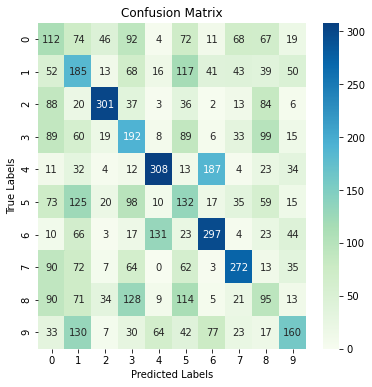

In [ ]:
y_test_arg = np.argmax(y_test, axis = 1)
y_pred_arg = np.argmax(y_pred, axis = 1)

draw_cm(y_test_arg, y_pred_arg, 'GnBu')

In [ ]:
# print(np.shape(y_test_arg))
# np.unique(y_test_arg)


In [ ]:
# print(np.shape(y_pred_arg))
# np.unique(y_pred_arg)

In [ ]:
print('Accuracy:', accuracy_score(y_test_arg, y_pred_arg))

Accuracy: 0.3423333333333333
